In [36]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import time

import brainflow
from brainflow.board_shim import BoardShim, BrainFlowInputParams, BrainFlowError, BoardIds


# Import the custom module.
from brainflow_stream import BrainFlowBoardSetup

In [37]:
board_id = BoardIds.CYTON_BOARD.value # Set the board_id to match the Cyton board

# Lets quickly take a look at the specifications of the Cyton board
for item1, item2 in BoardShim.get_board_descr(board_id).items():
    print(f"{item1}: {item2}")

accel_channels: [9, 10, 11]
analog_channels: [19, 20, 21]
ecg_channels: [1, 2, 3, 4, 5, 6, 7, 8]
eeg_channels: [1, 2, 3, 4, 5, 6, 7, 8]
eeg_names: Fp1,Fp2,C3,C4,P7,P8,O1,O2
emg_channels: [1, 2, 3, 4, 5, 6, 7, 8]
eog_channels: [1, 2, 3, 4, 5, 6, 7, 8]
marker_channel: 23
name: Cyton
num_rows: 24
other_channels: [12, 13, 14, 15, 16, 17, 18]
package_num_channel: 0
sampling_rate: 250
timestamp_channel: 22


In [26]:
cyton_board = BrainFlowBoardSetup(
                                board_id = board_id,
                                name = 'Board_1', # Optional name for the board. This is useful if you have multiple boards connected and want to distinguish between them.
                                serial_port = None # If the serial port is not specified, it will try to auto-detect the board. If this fails, you will have to assign the correct serial port. See https://docs.openbci.com/GettingStarted/Boards/CytonGS/ 
                                ) 

cyton_board.setup() # This will establish a connection to the board and start streaming data.

No serial port provided, attempting to auto-detect...
Compatible device found: Serial Number: DQ00859SA, Description: USB Serial Port (COM8)
[Board_1, COM8] Board setup and streaming started successfully.


In [27]:
board_info = cyton_board.get_board_info() # Retrieves the EEG channel and sampling rate of the board.
print(f"Board info: {board_info}")

board_srate = cyton_board.get_sampling_rate() # Retrieves the sampling rate of the board.
print(f"Board sampling rate: {board_srate}")

Board info: ([1, 2, 3, 4, 5, 6, 7, 8], 250)
Board sampling rate: 250


In [ ]:
raw_data_250 = cyton_board.get_current_board_data(250) # Get 250 samples of data from the board.

def remove_dc_offset(data):
    return data[1:9, :] - np.mean(data[1:9, :], axis=1, keepdims=True)
eeg_data = remove_dc_offset(raw_data_250) # Remove the DC offset from the data.



In [ ]:
time.sleep(5) # Wait for 5 seconds to allow the board to build up some samples into the buffer

raw_data_500 = cyton_board.get_current_board_data(num_samples = 500) # Get the latest 500 samples from the buffer
print(f"raw_data_1000 shape: {raw_data_500.shape}")

raw_data_all = cyton_board.get_board_data() 
print(f"raw_data_all shape: {raw_data_all.shape}")


raw_data_1000 shape: (24, 500)
raw_data_all shape: (24, 7335)
[[1.68000000e+02 1.69000000e+02 1.70000000e+02 ... 1.53000000e+02
  1.54000000e+02 1.55000000e+02]
 [1.87500000e+05 1.87500000e+05 1.87500000e+05 ... 1.87500000e+05
  1.87500000e+05 1.87500000e+05]
 [1.87500000e+05 1.87500000e+05 1.87500000e+05 ... 1.87500000e+05
  1.87500000e+05 1.87500000e+05]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.74213419e+09 1.74213419e+09 1.74213419e+09 ... 1.74213419e+09
  1.74213419e+09 1.74213419e+09]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


In [14]:
eeg_data = raw_data_500[1:9, :] # Get the EEG data from the first 8 channels
print(f"eeg_data shape: {eeg_data.shape}")

eeg_data shape: (8, 500)


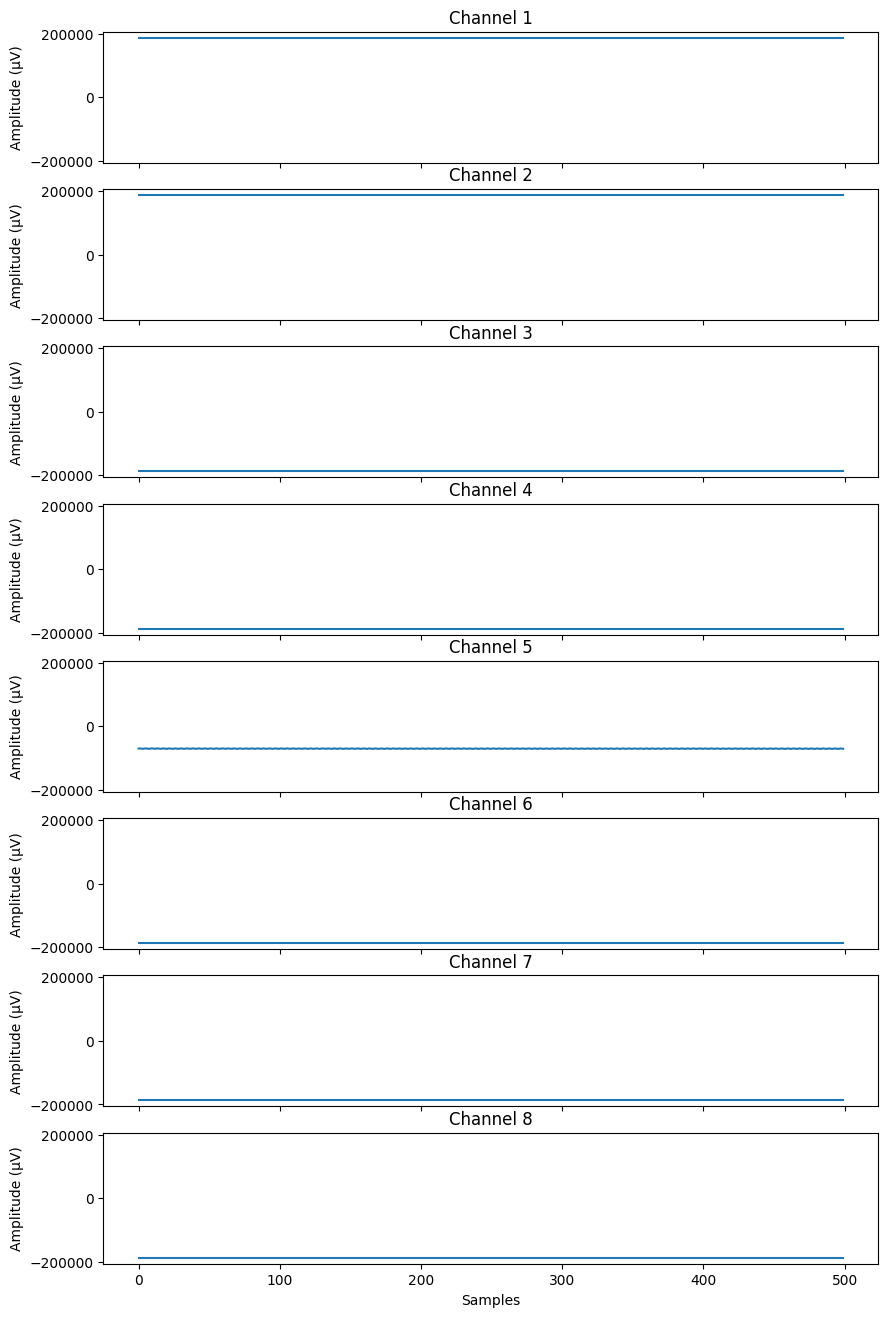

In [15]:
num_channels = eeg_data.shape[0]
num_samples = eeg_data.shape[1]

# Create a figure and a set of subplots
fig, axes = plt.subplots(num_channels, 1, figsize=(10, 2 * num_channels), sharex=True, sharey=True)

# Plot each channel
for i in range(num_channels):
    axes[i].plot(eeg_data[i, :])
    axes[i].set_title(f'Channel {i+1}')
    axes[i].set_ylabel('Amplitude (µV)')

axes[-1].set_xlabel('Samples')

plt.show()

In [16]:
# To do this we can subtract the mean of the data from the data itself. This will center the data around zero.
eeg_data_dc_removed = eeg_data - np.mean(eeg_data, axis=1, keepdims=True)

# While we're at it, lets make a small function that performs all of our minimal processing this since we'll have to do it every time we pull data from the board.
def remove_dc_offset(data):
    return data[1:9, :] - np.mean(data[1:9, :], axis=1, keepdims=True)

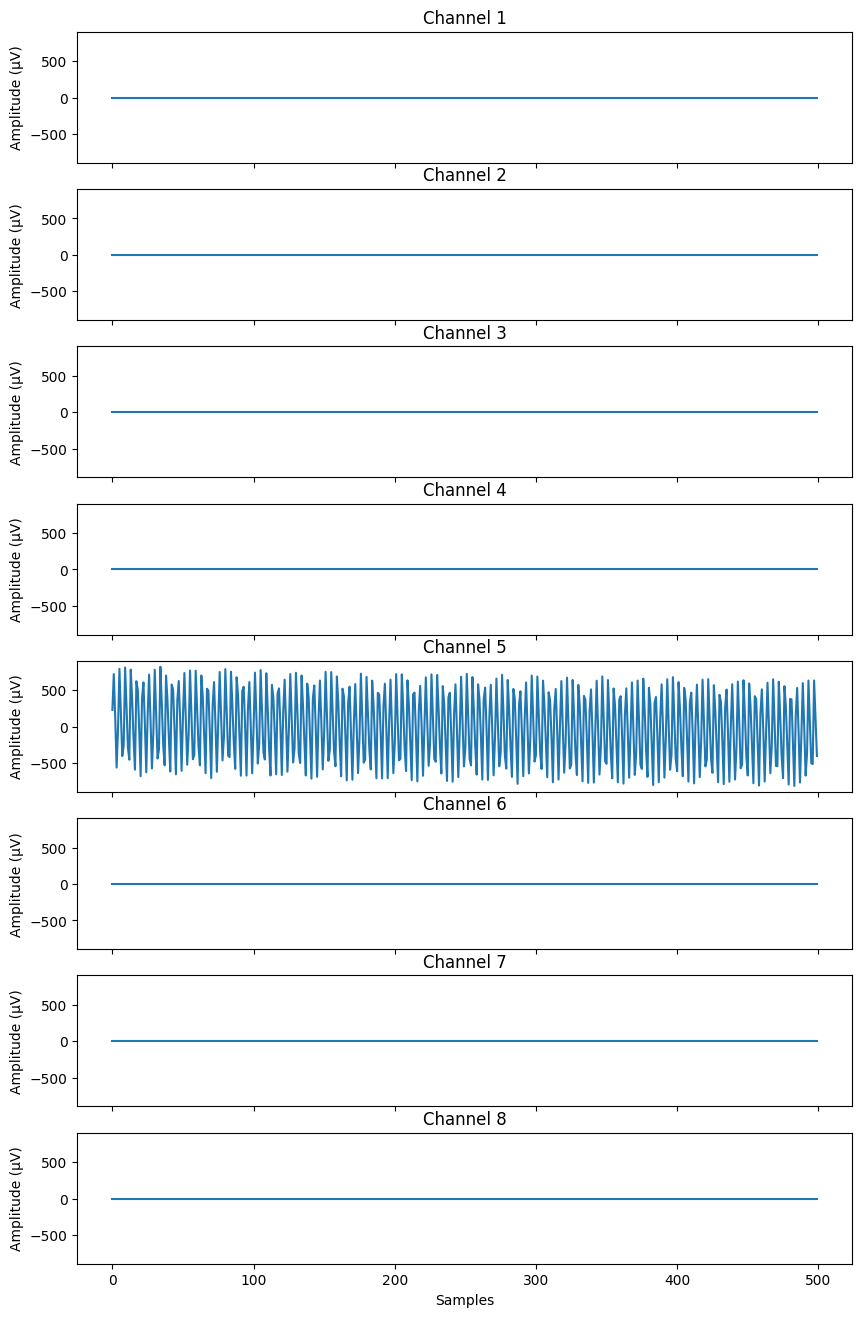

In [17]:
# Now let's plot the results
num_channels = eeg_data_dc_removed.shape[0]
num_samples = eeg_data_dc_removed.shape[1]

fig, axes = plt.subplots(num_channels, 1, figsize=(10, 2 * num_channels), sharex=True, sharey=True)

for i in range(num_channels):
    axes[i].plot(eeg_data_dc_removed[i, :])
    axes[i].set_title(f'Channel {i+1}')
    axes[i].set_ylabel('Amplitude (µV)')

axes[-1].set_xlabel('Samples')

plt.show()

In [ ]:
from scipy.signal import welch

def compute_band_power(eeg_data, fs, bands):
    """
    Compute power in specified frequency bands using Welch's method.

    Parameters:
    
eeg_data: np.array of shape (n_chans, n_samples)
fs: Sampling frequency in Hz
bands: Dictionary of band names and their (low, high) frequency ranges

    Returns:
    
band_powers: np.array of shape (n_chans, len(bands)), containing power in each band"""
    nchans, n_samples = eeg_data.shape
    band_powers = np.zeros((8, len(bands)))

    # Compute PSD using Welch’s method
    f, psd = welch(eeg_data, fs=fs) #, nperseg=fs2)  # nperseg = window size (2 sec recommended)

    for i, (band_name, (low, high)) in enumerate(bands.items()):
        # Find indices corresponding to the band range
        idx_band = np.where((f >= low) & (f <= high))[0]
        # Integrate the PSD over the selected frequency range
        band_powers[:, i] = np.trapz(psd[:, idx_band], f[idx_band])

    return band_powers

fs = 250  # Example sampling rate
bands = {"Delta": (0.5, 4), "Theta": (4, 8), "Alpha": (8, 13), "Beta": (13, 30), "Gamma": (30, 100)}
band_power = compute_band_power(eeg_data, fs, bands)
print(band_power)
print(eeg_data.shape)

[[8.44406500e+02 3.61721156e+01 2.61498700e+02 5.83771601e+02
  3.85563096e+05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.42198090e+03 7.47335319e+01 1.40160968e+04 6.57561786e+02
  1.41986887e+06]
 [1.01304700e+03 5.47586789e+01 2.33346231e+03 4.57879251e+02
  7.13203165e+05]
 [4.12858536e+03 2.14689910e+02 1.55653387e+02 5.05799870e+01
  1.25931034e+07]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [6.26420582e+02 7.81186466e+01 1.57261859e+03 6.36603342e+03
  2.50644594e+05]
 [2.52801453e+03 4.08938403e+01 1.45388822e+04 8.14080634e+02
  1.81620307e+06]]
(8, 250)


c:\Users\yuhan\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


In [35]:
def beta_alpha_ratio(band_powers, bands):
    # 获取 Beta 和 Alpha 频段在 band_powers 中的索引
    beta_idx = list(bands.keys()).index("Beta")
    alpha_idx = list(bands.keys()).index("Alpha")

    # 计算 Beta/Alpha 比值
    ratios = np.sum(band_powers[:, beta_idx], axis=-1) / np.sum(band_powers[:, alpha_idx], axis=-1)
    
    return ratios

# 假设 band_powers 是 compute_band_power 计算得到的结果
ratios = beta_alpha_ratio(band_power, bands)
print(ratios)

0.2716056051292038


In [ ]:
while time.time() - start_time < duration:
    eeg_data = simulate_eeg_data(n_chans, fs)  # 模拟 1 秒 EEG 数据
    band_power = compute_band_power(eeg_data, fs, bands)  # 计算频段功率
    ratio = beta_alpha_ratio(band_power, bands)  # 计算 Beta/Alpha 比值
    
    print(f"Beta/Alpha Ratio: {ratio}")  # 输出比值
    time.sleep(1)  # 等待 1 秒